In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import backend as K
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

from keras.applications import VGG16
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from keras.models import Model, load_model, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
from PIL import Image
from tqdm import tqdm, trange

/home/skkulab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nb_classes = 1  # number of classes
img_width, img_height = 224, 224  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-5  # sgd learning rate

## DIR ##

In [45]:
train_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/train'
validation_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/validation'
test50_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/test50'
test75_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/test75'
test95_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/test95'
test99_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/test99'

# AlexNet

In [4]:
img_input = Input(shape=(img_height, img_width, 3))

x = Conv2D(96, 11, strides=4, padding='same', use_bias=False)(img_input) # 15
x = Activation('relu')(x)

x = Conv2D(256, 5, strides=1, padding='same', use_bias=False)(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

x = Conv2D(384, 3, strides=1, padding='same', use_bias=False)(x) # 15
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

x = Conv2D(384, 3, strides=1, padding='same', use_bias=False)(x) # 15
x = Activation('relu')(x)
x = Conv2D(256, 3, strides=1, padding='same', use_bias=False)(x)
x = Activation('relu')(x)

model_out = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8
# Add fully connected layer
x = GlobalAveragePooling2D()(model_out)
x = Dense(4096, activation=None)(x)
x = Activation('relu')(x)
x = Dense(1, activation=None)(x)
out = Activation('sigmoid')(x)

model = Model(img_input, out)
print(model.summary())
print(len(model.trainable_weights))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34848     
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       614400    
_________________________________________________________________
activation_2 (Activation)    (None, 56, 56, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv

In [5]:
model.compile(optimizer=Adam(lr=learn_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

9


## Data generator

In [6]:
def generator(directory, batch_size=32):
    folder =  np.sort(os.listdir(directory))
    real_img = np.asarray(glob.glob(directory + '/' + folder[0]+'/*.png'))
    real_idx = np.arange(len(real_img))
    
    while 1:
        X1 = []
        X2 = []
        y = []
        
        if (len(real_idx) < batch_size):
            real_idx = np.arange(len(real_img))
            continue
        
        for _ in range(batch_size):
            if (len(real_idx) < batch_size):
                real_idx = np.arange(len(real_img))
                break
            random1 = np.random.choice(real_idx, 1, replace=False)
            real_idx = real_idx[~np.isin(real_idx, random1)]
            random2 = np.random.choice(real_idx, 1, replace=False)
            real_idx = real_idx[~np.isin(real_idx, random2)]
            X1.append(np.asarray(Image.open(real_img[random1[0]]).convert("RGB"))/255.)
            X2.append(np.asarray(Image.open(real_img[random2[0]]).convert("RGB"))/255.)
            y.append(np.array([0.]))

        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
        y = np.asarray(y)
        yield [X1, X2], y
        
def generator_res(ft_dir, directory, batch_size=1, critical_value=0.5):
    folder = np.sort(os.listdir(directory))
    ft_img = np.asarray(glob.glob(ft_dir + '/' + '0' +'/*.png'))
    ft_idx = np.arange(len(ft_img))
    random1 = np.random.choice(ft_idx, 1, replace=False)
    img = np.asarray(Image.open(ft_img[random1[0]]).convert("RGB"))/255.
    fake_img = np.asarray(glob.glob(directory + '/' + folder[1] + '/*.png'))
    fake_idx = np.arange(len(fake_img))
    real_img = np.asarray(glob.glob(directory + '/' + folder[0] + '/*.png'))
    real_idx = np.arange(len(real_img))
    while 1:
        X1 = []
        X2 = []
        y = []
        if (len(fake_idx) < batch_size):
            break
        if (len(real_idx) < batch_size):
            break
        for _ in range(batch_size):
            if np.random.uniform() > critical_value:
                if (len(fake_idx) < batch_size):
                    break
                random2 = np.random.choice(fake_idx, 1, replace=False)
                fake_idx = fake_idx[~np.isin(fake_idx, random2)]
                X1.append(img)
                X2.append(np.asarray(Image.open(fake_img[random2[0]]).convert("RGB"))/255.)
                y.append(np.array([1.]))
            else:
                if (len(real_idx) < batch_size):
                    break
                random3 = np.random.choice(real_idx, 1, replace=False)
                real_idx = real_idx[~np.isin(real_idx, random3)]
                X1.append(img)
                X2.append(np.asarray(Image.open(real_img[random3[0]]).convert("RGB"))/255.)
                y.append(np.array([0.]))
        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
        y = np.asarray(y)
        yield [X1, X2], y

In [7]:
def manDist(x):
    result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
    return result

def euclidean_distance(inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v + 1e-7)), axis=1, keepdims=True))  

def contrastive_loss(y_true,y_pred):
    margin=1.4
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))

def siamese_acc(y_true, y_pred):
    return K.mean((K.equal(y_true, K.cast(y_pred > 0.4, K.floatx()))), axis=1)

def y_pred_prt(y_true, y_pred):
    return y_pred

In [46]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test50_datagen = ImageDataGenerator(rescale=1./255)
test75_datagen = ImageDataGenerator(rescale=1./255)
test95_datagen = ImageDataGenerator(rescale=1./255)
test99_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='binary')

test50_generator = test50_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=128,
                                                  shuffle=True,
                                                  class_mode='binary')

test75_generator = test75_datagen.flow_from_directory(test75_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=128,
                                                  shuffle=True,
                                                  class_mode='binary')

test95_generator = test95_datagen.flow_from_directory(test95_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=128,
                                                  shuffle=True,
                                                  class_mode='binary')

test99_generator = test99_datagen.flow_from_directory(test99_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=128,
                                                  shuffle=True,
                                                  class_mode='binary')

Found 251702 images belonging to 2 classes.
Found 28298 images belonging to 2 classes.
Found 33086 images belonging to 2 classes.
Found 21866 images belonging to 2 classes.
Found 17480 images belonging to 2 classes.
Found 16723 images belonging to 2 classes.


In [75]:
ft_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/fine-tune'
train_gen = generator(ft_dir)
test50_gen = generator_res(ft_dir, test50_dir, batch_size=1, critical_value=0.5)
test75_gen = generator_res(ft_dir, test75_dir, batch_size=1, critical_value=0.75)
test95_gen = generator_res(ft_dir, test95_dir, batch_size=1, critical_value=0.95)
test99_gen = generator_res(ft_dir, test99_dir, batch_size=1, critical_value=0.988)

## Modeling

In [10]:
callback_list = [EarlyStopping(monitor='val_acc', patience=5),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]
history = model.fit_generator(train_generator,
                            steps_per_epoch=100,
                            epochs=20,
                            validation_data=validation_generator,
                            validation_steps=len(validation_generator),
                            callbacks=callback_list,
                            verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 136s 1s/step - loss: 0.6408 - acc: 0.6188 - val_loss: 0.4574 - val_acc: 0.9462
Epoch 2/20
100/100 [==============================] - 119s 1s/step - loss: 0.2337 - acc: 0.9397 - val_loss: 0.1978 - val_acc: 0.9281
Epoch 3/20
100/100 [==============================] - 118s 1s/step - loss: 0.1343 - acc: 0.9556 - val_loss: 0.1084 - val_acc: 0.9685
Epoch 4/20
100/100 [==============================] - 117s 1s/step - loss: 0.1168 - acc: 0.9609 - val_loss: 0.1214 - val_acc: 0.9618
Epoch 5/20
100/100 [==============================] - 116s 1s/step - loss: 0.0880 - acc: 0.9738 - val_loss: 0.0893 - val_acc: 0.9723
Epoch 6/20
100/100 [==============================] - 116s 1s/step - loss: 0.0967 - acc: 0.9697 - val_loss: 0.0906 - val_acc: 0.9742
Epoch 7/20
100/100 [==============================] - 116s 1s/step - loss: 0.0924 - acc: 0.9756 - val_loss: 0.0878 - val_acc: 0.9728
Epoch 8/20
100/100 [=

In [11]:
test50_classes = test50_generator.classes
print("50% ", len(test50_classes[test50_classes == 1]))
test75_classes = test75_generator.classes
print("75% ", len(test75_classes[test75_classes == 1]))
test95_classes = test95_generator.classes
print("95%: ", len(test95_classes[test95_classes == 1]))

50%  16543
75%  5323
95%:  937


In [12]:
model.save("kalexnet.h5")

### Siamese Modeling

In [10]:
model = load_model('alexnet.h5')
base_model = Model(img_input, out)
base_model.set_weights(model.get_weights())
for l in range(len(base_model.layers) - 2):
    base_model.layers[l].trainable = False   

im_in = Input(shape=(224, 224, 3))
x1 = base_model([im_in])

model_top = Model(inputs=[im_in], outputs=x1)
# model_top.load_weights("siam_alex.h5")
model_top.summary()

left_input = Input(shape=(224, 224, 3))
right_input = Input(shape=(224, 224, 3))

h1 = model_top(left_input)
h2 = model_top(right_input)

distance = Lambda(euclidean_distance)([h1, h2])
siam_model = Model(inputs=[left_input, right_input], outputs=distance)
siam_model.compile(loss='mse', optimizer=SGD(0.001), metrics=['acc'])
siam_model.summary()
callback_list = [EarlyStopping(monitor='acc', patience=3),
                 ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2)]
output = siam_model.fit_generator(train_gen, steps_per_epoch=40, epochs=10,callbacks=callback_list)

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
model_2 (Model)              (None, 1)                 4802593   
Total params: 4,802,593
Trainable params: 4,097
Non-trainable params: 4,798,496
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 224, 224, 3)  0                          

In [11]:
## siam model을 통째로 저장할 때 load err: axes doesn't match ##
''' model 설정 후, load weight '''
model_json = model_top.to_json()
with open("siam_alex.json", "w") as json_file:
    json_file.write(model_json)
model_top.save_weights("siam_alex1.h5")

## Evaluate Model - 50

In [12]:
model_1 = load_model("alexnet.h5")
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34848     
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       614400    
_________________________________________________________________
activation_2 (Activation)    (None, 56, 56, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 384)       884736    
__________

In [13]:
score50_1 = []
answer50_1 = []
for i in trange(len(test50_generator)):
    y_score50_1 = model_1.predict_on_batch(test50_generator[i][0])
    score50_1.append(y_score50_1)
    answer50_1.append(test50_generator[i][1])

score50_1 = np.concatenate(score50_1)
answer50_1 = np.concatenate(answer50_1)

y_hat50_1 = score50_1.copy()
y_hat50_1[y_hat50_1 >= 0.5] = 1.
y_hat50_1[y_hat50_1 < 0.5] = 0.

cm50_1 = confusion_matrix(answer50_1, y_hat50_1)
recall50_1 = cm50_1[0][0] / (cm50_1[0][0] + cm50_1[0][1])
fallout50_1 = cm50_1[1][0] / (cm50_1[1][0] + cm50_1[1][1])
fpr50_1, tpr50_1, thresholds50_1 = roc_curve(answer50_1, score50_1, pos_label=1.)
eer50_1 = brentq(lambda x : 1. - x - interp1d(fpr50_1, tpr50_1)(x), 0., 1.)
thresh50_1 = interp1d(fpr50_1, thresholds50_1)(eer50_1)

100%|██████████| 259/259 [05:53<00:00,  1.11s/it]


In [37]:
print(metrics.classification_report(answer50_1, y_hat50_1))
print(confusion_matrix(answer50_1, y_hat50_1))
print("FPR=FAR", fallout50_1)
print("FNR=FRR", 1-recall50_1)
print('test_acc: ', len(y_hat50_1[np.equal(y_hat50_1.reshape(-1), answer50_1)]) / len(y_hat50_1))
print('thresh:', thresh50_1)
print('eer:', eer50_1)
print('aou_roc: ', roc_auc_score(answer50_1, score50_1))
print(cm50_1)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     16543
         1.0       0.96      1.00      0.98     16543

    accuracy                           0.98     33086
   macro avg       0.98      0.98      0.98     33086
weighted avg       0.98      0.98      0.98     33086

[[15917   626]
 [    0 16543]]
FPR=FAR 0.0
FNR=FRR 0.0378407785770416
test_acc:  0.9810796107114792
thresh: 0.934641599656215
eer: 0.01348002176132881
aou_roc:  0.9931602141520013
[[15917   626]
 [    0 16543]]


In [15]:
score50_2 = []
answer50_2 = []
for i in tqdm(test50_gen):
    y_score50_2 = siam_model.predict_on_batch(i[0])
    score50_2.append(y_score50_2)
    answer50_2.append(i[1])
    
score50_2 = np.concatenate(score50_2)
answer50_2 = np.concatenate(answer50_2)

33017it [06:03, 90.74it/s] 


In [16]:
y_hat50_2 = score50_2.copy()
y_hat50_2[y_hat50_2 >= 0.9] = 1.
y_hat50_2[y_hat50_2 < 0.9] = 0.

cm50_2 = confusion_matrix(answer50_2, y_hat50_2)
recall50_2 = cm50_2[0][0] / (cm50_2[0][0] + cm50_2[0][1])
fallout50_2 = cm50_2[1][0] / (cm50_2[1][0] + cm50_2[1][1])
fpr50_2, tpr50_2, thresholds50_2 = roc_curve(answer50_2, score50_2, pos_label=1.)
eer50_2 = brentq(lambda x : 1. - x - interp1d(fpr50_2, tpr50_2)(x), 0., 1.)
thresh50_2 = interp1d(fpr50_2, thresholds50_2)(eer50_2)

In [38]:
print(metrics.classification_report(answer50_2, y_hat50_2))
print(confusion_matrix(answer50_2, y_hat50_2))
print("FPR=FAR", fallout50_2)
print("FNR=FRR", 1-recall50_2)
print('test_acc: ', len(y_hat50_2[np.equal(y_hat50_2, answer50_2)]) / len(y_hat50_2))
print('thresh:', thresh50_2)
print('eer:', eer50_2)
print('aou_roc: ', roc_auc_score(answer50_2, score50_2))
print(cm50_2)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     16474
         1.0       0.99      0.98      0.98     16543

    accuracy                           0.98     33017
   macro avg       0.98      0.98      0.98     33017
weighted avg       0.98      0.98      0.98     33017

[[16283   191]
 [  321 16222]]
FPR=FAR 0.019403977513147555
FNR=FRR 0.011594026951560088
test_acc:  0.9844928370233516
thresh: 0.8894331832312993
eer: 0.0120890314470861
aou_roc:  0.994327679501361
[[16283   191]
 [  321 16222]]


## Evaluate Model - 75

In [18]:
score75_1 = []
answer75_1 = []
for i in trange(len(test75_generator)):
    y_score75_1 = model_1.predict_on_batch(test75_generator[i][0])
    score75_1.append(y_score75_1)
    answer75_1.append(test75_generator[i][1])

score75_1 = np.concatenate(score75_1)
answer75_1 = np.concatenate(answer75_1)

y_hat75_1 = score75_1.copy()
y_hat75_1[y_hat75_1 >= 0.5] = 1.
y_hat75_1[y_hat75_1 < 0.5] = 0.

cm75_1 = confusion_matrix(answer75_1, y_hat75_1)
recall75_1 = cm75_1[0][0] / (cm75_1[0][0] + cm75_1[0][1])
fallout75_1 = cm75_1[1][0] / (cm75_1[1][0] + cm75_1[1][1])
fpr75_1, tpr75_1, thresholds75_1 = roc_curve(answer75_1, score75_1, pos_label=1.)
eer75_1 = brentq(lambda x : 1. - x - interp1d(fpr75_1, tpr75_1)(x), 0., 1.)
thresh75_1 = interp1d(fpr75_1, thresholds75_1)(eer75_1)

100%|██████████| 171/171 [03:21<00:00,  1.22s/it]


In [39]:
print(metrics.classification_report(answer75_1, y_hat75_1))
print(confusion_matrix(answer75_1, y_hat75_1))
print("FPR=FAR", fallout75_1)
print("FNR=FRR", 1-recall75_1)
print('test_acc: ', len(y_hat75_1[np.equal(y_hat75_1.reshape(-1), answer75_1)]) / len(y_hat75_1))
print('thresh:', thresh75_1)
print('eer:', eer75_1)
print('aou_roc: ', roc_auc_score(answer75_1, score75_1))
print(cm75_1)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     16543
         1.0       0.89      1.00      0.94      5323

    accuracy                           0.97     21866
   macro avg       0.95      0.98      0.96     21866
weighted avg       0.97      0.97      0.97     21866

[[15917   626]
 [    0  5323]]
FPR=FAR 0.0
FNR=FRR 0.0378407785770416
test_acc:  0.9713710783865361
thresh: 0.9339713650000188
eer: 0.013445484242586835
aou_roc:  0.9931584996405055
[[15917   626]
 [    0  5323]]


In [20]:
score75_2 = []
answer75_2 = []
j = 0
for i in tqdm(test75_gen):
    y_score75_2 = siam_model.predict_on_batch(i[0])
    score75_2.append(y_score75_2)
    answer75_2.append(i[1])
    j += 1
    
score75_2 = np.concatenate(score75_2)
answer75_2 = np.concatenate(answer75_2)

21404it [03:56, 90.36it/s]


In [21]:
y_hat75_2 = score75_2.copy()
y_hat75_2[y_hat75_2 >= 0.9] = 1.
y_hat75_2[y_hat75_2 < 0.9] = 0.

cm75_2 = confusion_matrix(answer75_2, y_hat75_2)
recall75_2 = cm75_2[0][0] / (cm75_2[0][0] + cm75_2[0][1])
fallout75_2 = cm75_2[1][0] / (cm75_2[1][0] + cm75_2[1][1])
fpr75_2, tpr75_2, thresholds75_2 = roc_curve(answer75_2, score75_2, pos_label=1.)
eer75_2 = brentq(lambda x : 1. - x - interp1d(fpr75_2, tpr75_2)(x), 0., 1.)
thresh75_2 = interp1d(fpr75_2, thresholds75_2)(eer75_2)

In [40]:
print(metrics.classification_report(answer75_2, y_hat75_2))
print(confusion_matrix(answer75_2, y_hat75_2))
print("FPR=FAR", fallout75_2)
print("FNR=FRR", 1-recall75_2)
print('test_acc: ', len(y_hat75_2[np.equal(y_hat75_2, answer75_2)]) / len(y_hat75_2))
print('thresh:', thresh75_2)
print('eer:', eer75_2)
print('aou_roc: ', roc_auc_score(answer75_2, score75_2))
print(cm75_2)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     16081
         1.0       0.97      0.98      0.97      5323

    accuracy                           0.99     21404
   macro avg       0.98      0.98      0.98     21404
weighted avg       0.99      0.99      0.99     21404

[[15894   187]
 [  102  5221]]
FPR=FAR 0.01916212662032688
FNR=FRR 0.011628630060319667
test_acc:  0.9864978508689964
thresh: 0.8885724049251125
eer: 0.012211159120870499
aou_roc:  0.9942520699647495
[[15894   187]
 [  102  5221]]


## Evaluate Model - 95

In [ ]:
score95_1 = []
answer95_1 = []
for i in trange(len(test95_generator)):
    y_score95_1 = model_1.predict_on_batch(test95_generator[i][0])
    score95_1.append(y_score95_1)
    answer95_1.append(test95_generator[i][1])

score95_1 = np.concatenate(score95_1)
answer95_1 = np.concatenate(answer95_1)

y_hat95_1 = score95_1.copy()
y_hat95_1[y_hat95_1 >= 0.5] = 1.
y_hat95_1[y_hat95_1 < 0.5] = 0.

cm95_1 = confusion_matrix(answer95_1, y_hat95_1)
recall95_1 = cm95_1[0][0] / (cm95_1[0][0] + cm95_1[0][1])
fallout95_1 = cm95_1[1][0] / (cm95_1[1][0] + cm95_1[1][1])
fpr95_1, tpr95_1, thresholds95_1 = roc_curve(answer95_1, score95_1, pos_label=1.)
eer95_1 = brentq(lambda x : 1. - x - interp1d(fpr95_1, tpr95_1)(x), 0., 1.)
thresh95_1 = interp1d(fpr95_1, thresholds95_1)(eer95_1)

In [ ]:
print(metrics.classification_report(answer95_1, y_hat95_1))
print(confusion_matrix(answer95_1, y_hat95_1))
print("FPR=FAR", fallout95_1)
print("FNR=FRR", 1-recall95_1)
print('test_acc: ', len(y_hat95_1[np.equal(y_hat95_1.reshape(-1), answer95_1)]) / len(y_hat95_1))
print('thresh:', thresh95_1)
print('eer:', eer95_1)
print('aou_roc: ', roc_auc_score(answer95_1, score95_1))
print(cm95_1)

In [ ]:
score95_2 = []
answer95_2 = []
j = 0
for i in tqdm(test95_gen):
    y_score95_2 = siam_model.predict_on_batch(i[0])
    score95_2.append(y_score95_2)
    answer95_2.append(i[1])
    j += 1
    
score95_2 = np.concatenate(score95_2)
answer95_2 = np.concatenate(answer95_2)

In [ ]:
y_hat95_2 = score95_2.copy()
y_hat95_2[y_hat95_2 >= 0.9] = 1.
y_hat95_2[y_hat95_2 < 0.9] = 0.

cm95_2 = confusion_matrix(answer95_2, y_hat95_2)
recall95_2 = cm95_2[0][0] / (cm95_2[0][0] + cm95_2[0][1])
fallout95_2 = cm95_2[1][0] / (cm95_2[1][0] + cm95_2[1][1])
fpr95_2, tpr95_2, thresholds95_2 = roc_curve(answer95_2, score95_2, pos_label=1.)
eer95_2 = brentq(lambda x : 1. - x - interp1d(fpr95_2, tpr95_2)(x), 0., 1.)
thresh95_2 = interp1d(fpr95_2, thresholds95_2)(eer95_2)

In [ ]:
print(metrics.classification_report(answer95_2, y_hat95_2))
print(confusion_matrix(answer95_2, y_hat95_2))
print("FPR=FAR", fallout95_2)
print("FNR=FRR", 1-recall95_2)
print('test_acc: ', len(y_hat95_2[np.equal(y_hat95_2, answer95_2)]) / len(y_hat95_2))
print('thresh:', thresh95_2)
print('eer:', eer95_2)
print('aou_roc: ', roc_auc_score(answer95_2, score95_2))
print(cm95_2)

## Evaluate Model - 99

In [48]:
score99_1 = []
answer99_1 = []
for i in trange(len(test99_generator)):
    y_score99_1 = model_1.predict_on_batch(test99_generator[i][0])
    score99_1.append(y_score99_1)
    answer99_1.append(test99_generator[i][1])

score99_1 = np.concatenate(score99_1)
answer99_1 = np.concatenate(answer99_1)

y_hat99_1 = score99_1.copy()
y_hat99_1[y_hat99_1 >= 0.5] = 1.
y_hat99_1[y_hat99_1 < 0.5] = 0.

cm99_1 = confusion_matrix(answer99_1, y_hat99_1)
recall99_1 = cm99_1[0][0] / (cm99_1[0][0] + cm99_1[0][1])
fallout99_1 = cm99_1[1][0] / (cm99_1[1][0] + cm99_1[1][1])
fpr99_1, tpr99_1, thresholds99_1 = roc_curve(answer99_1, score99_1, pos_label=1.)
eer99_1 = brentq(lambda x : 1. - x - interp1d(fpr99_1, tpr99_1)(x), 0., 1.)
thresh99_1 = interp1d(fpr99_1, thresholds99_1)(eer99_1)

100%|██████████| 131/131 [04:23<00:00,  1.76s/it]


In [49]:
print(metrics.classification_report(answer99_1, y_hat99_1))
print(confusion_matrix(answer99_1, y_hat99_1))
print("FPR=FAR", fallout99_1)
print("FNR=FRR", 1-recall99_1)
print('test_acc: ', len(y_hat99_1[np.equal(y_hat99_1.reshape(-1), answer99_1)]) / len(y_hat99_1))
print('thresh:', thresh99_1)
print('eer:', eer99_1)
print('aou_roc: ', roc_auc_score(answer99_1, score99_1))
print(cm99_1)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     16543
         1.0       0.22      1.00      0.37       180

    accuracy                           0.96     16723
   macro avg       0.61      0.98      0.67     16723
weighted avg       0.99      0.96      0.97     16723

[[15917   626]
 [    0   180]]
FPR=FAR 0.0
FNR=FRR 0.0378407785770416
test_acc:  0.9625665251450098
thresh: 0.9444412347452743
eer: 0.012482991184996746
aou_roc:  0.9928647229106639
[[15917   626]
 [    0   180]]


In [76]:
score99_2 = []
answer99_2 = []
j = 0
for i in tqdm(test99_gen):
    y_score99_2 = siam_model.predict_on_batch(i[0])
    score99_2.append(y_score99_2)
    answer99_2.append(i[1])
    j += 1
    
score99_2 = np.concatenate(score99_2)
answer99_2 = np.concatenate(answer99_2)

14608it [02:33, 94.90it/s] 


In [77]:
y_hat99_2 = score99_2.copy()
y_hat99_2[y_hat99_2 >= 0.9] = 1.
y_hat99_2[y_hat99_2 < 0.9] = 0.

cm99_2 = confusion_matrix(answer99_2, y_hat99_2)
recall99_2 = cm99_2[0][0] / (cm99_2[0][0] + cm99_2[0][1])
fallout99_2 = cm99_2[1][0] / (cm99_2[1][0] + cm99_2[1][1])
fpr99_2, tpr99_2, thresholds99_2 = roc_curve(answer99_2, score99_2, pos_label=1.)
eer99_2 = brentq(lambda x : 1. - x - interp1d(fpr99_2, tpr99_2)(x), 0., 1.)
thresh99_2 = interp1d(fpr99_2, thresholds99_2)(eer99_2)

In [78]:
print(metrics.classification_report(answer99_2, y_hat99_2))
print(confusion_matrix(answer99_2, y_hat99_2))
print("FPR=FAR", fallout99_2)
print("FNR=FRR", 1-recall99_2)
print('test_acc: ', len(y_hat99_2[np.equal(y_hat99_2, answer99_2)]) / len(y_hat99_2))
print('thresh:', thresh99_2)
print('eer:', eer99_2)
print('aou_roc: ', roc_auc_score(answer99_2, score99_2))
print(cm99_2)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     14428
         1.0       0.52      0.99      0.68       180

    accuracy                           0.99     14608
   macro avg       0.76      0.99      0.84     14608
weighted avg       0.99      0.99      0.99     14608

[[14261   167]
 [    2   178]]
FPR=FAR 0.011111111111111112
FNR=FRR 0.011574715830329874
test_acc:  0.9884309967141293
thresh: 0.9019187092631807
eer: 0.011436096479879289
aou_roc:  0.9939889258540493
[[14261   167]
 [    2   178]]


## Plotting

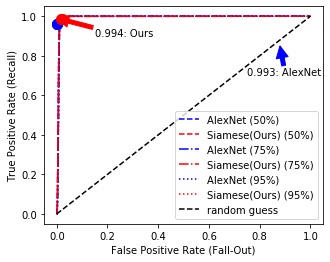

In [44]:
plt.figure(figsize=(5,4))
plt.plot(fpr50_1, tpr50_1, 'b--', label="AlexNet (50%)")
plt.plot(fpr50_2, tpr50_2, 'r--', label="Siamese(Ours) (50%)")
plt.plot(fpr75_1, tpr75_1, 'b-.', label="AlexNet (75%)")
plt.plot(fpr75_2, tpr75_2, 'r-.', label="Siamese(Ours) (75%)")
plt.plot(fpr95_1, tpr95_1, 'b:', label="AlexNet (95%)")
plt.plot(fpr95_2, tpr95_2, 'r:', label="Siamese(Ours) (95%)")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout50_1], [recall50_1], 'bo', ms=10)
plt.plot([fallout50_2], [recall50_2], 'ro', ms=10)
plt.plot([fallout75_1], [recall75_1], 'bo', ms=10)
plt.plot([fallout75_2], [recall75_2], 'ro', ms=10)
plt.plot([fallout95_1], [recall95_1], 'bo', ms=10)
plt.plot([fallout95_2], [recall95_2], 'ro', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
# plt.title("Best AUROC: %.3f / Model: Ours" %(roc_auc_score(answer50_2, score)))
plt.legend(loc='lower right')
plt.annotate("%.3f: AlexNet" %(roc_auc_score(answer95_1, score95_1)), xy=(0.88, 0.85), xytext=(0.75, 0.70), arrowprops={'color':'blue'})
plt.annotate("%.3f: Ours" %(roc_auc_score(answer95_2, score95_2)), xy=(0.0, 0.99), xytext=(0.15, 0.9), arrowprops={'color':'red'})
plt.show()